### Sentiment Analysis on "Jallikattu" with Twitter Data Feed <h3 style="color:red;">#DataScienceForSocialCause</h3>

Twitter is flooded with Jallikattu issue, let us find peoples sentiment with Data Science tools. Following is the approach
* Register a Twitter API handle for data feed
* Pull out tweets on search query 'jallikattu' 
* Using NLP packages find the sentiment of the tweet (Positive, Neutral or Negative)
* Plot pie chart of the sentiment 
* Plot a masked word cloud of tags used

Finall output we expect is a masked word cloud of popular tags used in twitter with font size propotional to the frequency of use. Let's dive in ...

### Loading necessary packages

In particular we will be using tweepy to register an api handle with twitter and get the data feed. [Tweepy Document](http://docs.tweepy.org/en/v3.5.0/)
TextBlob package to determine the sentiment of the tweets. [TextBlob Document](https://textblob.readthedocs.io/en/dev/)



In [1]:
# import tweepy for twitter datastream and textblob for processing tweets
import tweepy
import textblob

# wordcloud package is used to produce the cool masked tag cloud above
from wordcloud import WordCloud

# pickle to serialize/deserialize python objects
import pickle

# regex package to extract hasttags from tweets
import re

# os for loading files from local system, matplotlib, np and PIL for ploting
from os import path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### We will create a Twitter API handle for fetching data

* Inorder to qualify for a Twitter API handle you need to be a **`Phone Verified`** Twitter user. 
    1. Goto Twitter settings page [twitter.com/settings/account](https://twitter.com/settings/account)
    2. Choose Mobile tab on left pane, then enter your phone number and verify by OTP
    3. Now you should be able to register new API handle for your account for `programmatic tweeting`
    
 
* Now goto Twitter [Application Management](https://apps.twitter.com/) page
* Click *Create New App*button 
    1. Enter a Unique App name(global namespace), you might have to try few time to get it correct
    2. Description can be anything you wish
    3. website can be some <yourname>.com, you dont really have to own the domain
    4. Leave the callback URL empty, agree to the terms and condition unconditionally 
    5. Click create
    
    
* You can find the api credentials in [Application Management](https://apps.twitter.com/) consol
* Choose the App and goto *keys and access tokens* tab to get API_KEY, API_SECRET, ACCESS_TOKEN and ACCESS_TOKEN_SECRET

#### RUN THE CODE BLOCK BELOW ONLY ON FIRST TIME YOU CONFIGURE THE TWITTER API

In [ ]:
# make sure to exclued this folder in git ignore
path_to_cred_file = path.abspath('../restricted/api_credentials.p')

# we will store twitter handle credentials in a pickle file (object de-serialization)
# code for pickling credentials need to be run only once during initial configuration
# fill the following dictionary with your twitter credentials
twitter_credentials = {'api_key':'API_KEY', \
                       'api_secret':'API_SECRET', \
                       'access_token':'ACCESS_TOKEN', \
                       'access_token_secret':'ACCESS_TOKEN_SECRET'}
pickle.dump(twitter_credentials,open(path_to_cred_file, "wb"))
print("Pickled credentials saved to :\n"+path_to_cred_file+"\n")
print("\n".join(["{:20} : {}".format(key,value) for key,value in twitter_credentials.items()]))

#### From second run you can load the credentials securely form stored file
If you want to check the credentials uncomment the last line in below code block

In [2]:
# make sure to exclued this folder in git ignore
path_to_cred_file = path.abspath('../restricted/api_credentials.p')

# load saved twitter credentials
twitter_credentials = pickle.load(open(path_to_cred_file,'rb'))
#print("\n".join(["{:20} : {}".format(key,value) for key,value in twitter_credentials.items()]))

### Creating an Open Auth Instance
With the created api and token we will open an open auth instance to authenticate our twitter account.

If you feel that your twitter api credentials have been compromised you can just generate a new set of access token-secret pair, access token is like RSA to authenticate your api key.

In [3]:
# lets create an open authentication handler and initialize it with our twitter handlers api key
auth = tweepy.OAuthHandler(twitter_credentials['api_key'],twitter_credentials['api_secret'])

# access token is like password for the api key, 
auth.set_access_token(twitter_credentials['access_token'],twitter_credentials['access_token_secret'])

### Twitter API Handle

Tweepy comes with a Twitter API wrapper class called 'API', passing the open auth instance to this API creates a live Twitter handle to our account.


**ATTENTION: Please beware that this is a handle you your own account not any pseudo account, if you tweet something with this it will be your tweet** This is the reason I took care not to expose my api credentials, if you expose anyone can mess up your Twitter account.


Let's open the twitter handle and print the Name and Location of the twitter account owner, you should be seeing your name.

In [4]:
# lets create an instance of twitter api wrapper
api = tweepy.API(auth)

# lets do some self check
user = api.me()
print("{}\n{}".format(user.name,user.location))

Prabakaran
Chennai, India


### Inspiration for this Project 
I drew inspiration for this project from the ongoing issue on traditional bull fighting AKA *Jallikattu*. Here I'm trying read  pulse of the people based on tweets.

We are searching for key word *Jallikattu* in Twitters public tweets, in the retured search result we are taking 150 tweets to do our **Sentiment Analysis**. Please dont go for large number of tweets there is an upper limit of 450 tweets, for more on api rate limits checkout [Twitter Developer Doc](https://dev.twitter.com/rest/public/rate-limits).

In [5]:
# now lets get some data to check the sentiment on it
# lets search for key word jallikattu and check the sentiment on it
query = 'jallikattu'
tweet_cnt = 150
peta_tweets = api.search(q=query,count=tweet_cnt)

### Processing Tweets

Once we get the tweets, we will iterate through the tweets and do following oprations
1. Pass the tweet text to TextBlob to process the tweet
2. Processed tweets will have two attributes 
  * Polarity which is a numerical value between -1 to 1, the sentiment of the text can be infered from this.
  * Subjectivity this shows wheather the text is stated as a fact or an opinion, value ranges from 0 to 1
3. For each tweet we will find sentiment of the text (positive, neutral or negative) and update a counter variable accordingly, this counter is later ploted as a **pie chart**.
4. Then we pass the tweet text to a regular expression to extract hash tags, which we later use to create an awesome **word cloud visualization**.

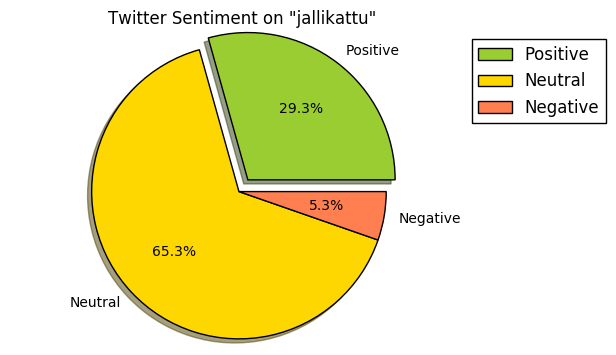

In [6]:
# lets go over the tweets 
sentiment_polarity = [0,0,0]
tags = []

for tweet in peta_tweets:
    processed_tweet = textblob.TextBlob(tweet.text)
    polarity = processed_tweet.sentiment.polarity
    upd_index = 0 if polarity > 0 else (1 if polarity == 0 else 2)
    sentiment_polarity[upd_index] = sentiment_polarity[upd_index]+1
    tags.extend(re.findall(r"#(\w+)", tweet.text))
    #print(tweet.text)
    #print(processed_tweet.sentiment,'\n')

sentiment_label = ['Positive','Neutral','Negative']
#print("\n".join(["{:8} tweets count {}".format(s,val) for s,val in zip(sentiment_label,sentiment_polarity)]))

# plotting sentiment pie chart
colors = ['yellowgreen', 'gold', 'coral']

# lets explode the positive sentiment for visual appeal
explode = (0.1, 0, 0)
plt.pie(sentiment_polarity,labels=sentiment_label,colors=colors,explode=explode,shadow=True,autopct='%1.1f%%')
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.3,1))
plt.title('Twitter Sentiment on \"'+query+'\"')
plt.show()

### Sentiment Analysis

We can see that majority is neutral which is contributed by 
1. Tweets with media only(photo, video) 
2. Tweets in regional language. Textblob do not work on our indian languages.
3. Some tweets contains only stop words or the words that do not give any positive or negative perspective. 
4. Polarity is calculated by the number of positive words like "great, awesome, etc." or negative words like "hate, bad, etc"

One more point to note is that TextBlob is not a complete NLP package it does not do context aware search, such sophisticated deep learing abilities are available only with likes of Google.

In [7]:
# lets process the hash tags in the tweets and make a word cloud visualization
# normalizing tags by converting all tags to lowercase
tags = [t.lower() for t in tags]

# get unique count of tags to take count for each
uniq_tags = list(set(tags))
tag_count = []

# for each unique hash tag take frequency of occurance
for tag in uniq_tags:
    tag_count.append((tag,tags.count(tag)))

# lets print the top five tags 
tag_count =sorted(tag_count,key=lambda x:-x[1])[:5]
print("\n".join(["{:8}  {}".format(tag,val) for tag,val in tag_count]))

jallikattu  75
justiceforjallikattu  37
vijay     13
marina    8
ilayathalapathy  8


### Simple Word Cloud with Twitter #tags

Let us viualize the tags used in for Jallikattu by creating a tag cloud. The wordcloud package takes a single string of tags separated by whitespace. We will concatinate the tags and pass it to generate method to create a tag cloud image.

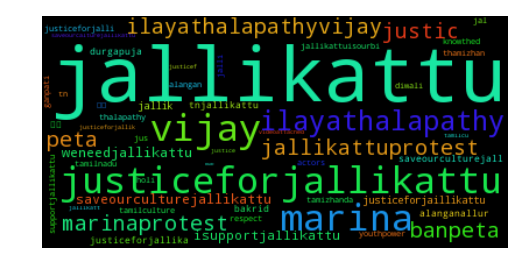

In [8]:
# we will create a vivid tag cloud visualization 
# creating a single string of texts from tags, the tag's font size is proportional to its frequency
text = " ".join(tags)

# this generates an image from the long string, if you wish you may save it to local
wc = WordCloud().generate(text)

# we will display the image with matplotlibs image show, removed x and y axis ticks
plt.imshow(wc)
plt.axis("off")
plt.show()

### Masked Word Cloud

The tag cloud can be masked using a grascale stencil image the wordcloud package neatly arranges the word in side the mask image. I have supreimposed generated word cloud image on to the mask image to provide a detailing otherwise the background of the word cloud will be white and it will appeare like words are hanging in space instead.


Inorder to make the image superimposing work well, we need to manipulate image transparency using image alpha channel. If you look at the visual only fine detail of mask image is seen in the tag cloud this is bacause word cloud is layed on mask image and the transparency of word cloud image is 90% so only 10% of mask image is seen.

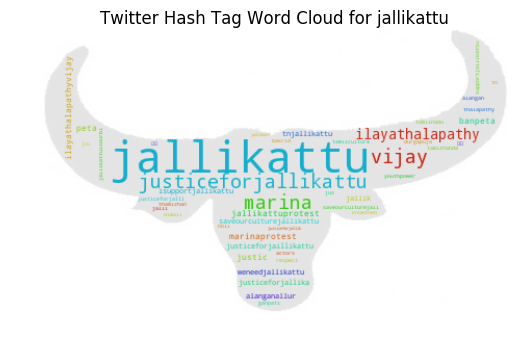

In [11]:
# we can also create a masked word cloud from the tags by using grayscale image as stencil
# lets load the mask image from local
bull_mask = np.array(Image.open(path.abspath('../asset/bull_mask_1.jpg')))

wc_mask = WordCloud(background_color="white", mask=bull_mask).generate(text)
mask_image = plt.imshow(bull_mask, cmap=plt.cm.gray)
word_cloud = plt.imshow(wc_mask,alpha=0.9)
plt.axis("off")
plt.title("Twitter Hash Tag Word Cloud for "+query)
plt.show()

The tag cloud marks the key moments like the call for protest in Chennai Marina, Alanganallur. Also shows one of a leading actors support for the cause and calls for ban on peta.

This code will give different output over time as new tweet are added in timeline and old ones are pushed down, 

#### Thank you for showing intrest in my work
If you liked it and want to be notified of my future work follow me on 


[Knowme](https://knome.ultimatix.net/users/286632-prabakaran-k)


[@iPrabakaran](https://twitter.com/iPrabakaran) Twitter


[GitHub](https://github.com/nixphix)